In [ ]:
import warnings
warnings.filterwarnings('ignore')

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay

from qsar.gan.gan_featurizer import QsarGanFeaturizer
from qsar.gan.qsar_gan import QsarGan
from qsar.gan.extract_descriptors import DescriptorsExtractor
from qsar.utils.visualizer import Visualizer

# Dataset Compilation for QSAR Modeling

In this section, we compile various datasets for use in QSAR (Quantitative Structure-Activity Relationship) modeling, focusing on chemical structures represented as SMILES (Simplified Molecular Input Line Entry System) strings.

1. **Local Dataset**: The primary dataset consists of 183 unique chemical structures (SMILES format), sourced from a local file. This dataset is primarily used for initial model training and validation.
2. **Tox21 Dataset**: Contains bioactivity data for various chemicals in toxicity assays. Utilized in toxicology research and safety assessments, it aids in understanding the toxicological profiles of substances. Source: [Tox21](https://paperswithcode.com/dataset/tox21-1).
3. **Lipo Dataset**: Provides data on the lipophilicity (logP values) of chemical compounds. This is crucial for studying compound absorption and metabolism, relevant in pharmacological contexts. Source: [Lipo](https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/).


In [2]:
# our dataset (183 smiles)
df = pd.read_csv('../../data/unfiltered_data_smiles.csv')
data_local = df[['SMILES']]
data_local.columns = [col.lower() for col in data_local.columns]

_, datasets, _ = dc.molnet.load_tox21(reload=False)
data_tox21 = pd.DataFrame(data={'smiles': datasets[0].ids})

_, datasets, _ = dc.molnet.load_lipo(reload=False)
data_lipo = pd.DataFrame(data={'smiles': datasets[0].ids})

# Combining all datasets might maximise the GAN perf and boost the prediction
data = pd.concat([data_local, data_tox21, data_lipo], ignore_index=True)
display(data)

,smiles
0,O=C(Nc1ccc(O)cc1)C
1,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,S(=O)(=O)(N)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...
3,S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
4,OCC
...,...
9802,Nc1scc2C(=NN(C(=O)c12)c3ccc(F)cc3)C(=O)NC4CC4
9803,O=C(NC1(CC1)C#N)[C@@H]2CCCC[C@H]2C(=O)N3CCc4[n...
9804,Cn1cnc(c1Sc2ncnc3nc[nH]c23)[N+](=O)[O-]
9805,OCCN1CCN(Cc2ccc3c(NC(=O)CC45CC6CC(CC(C6)C4)C5)...


# Determine the max atom count threshold

In this part of the workflow, we utilize two main components: `QsarGanFeaturizer` and `Visualizer`, to process and analyze our compiled chemical structure data represented in SMILES format.

1. **Featurization**:
    - We employ the `QsarGanFeaturizer` to analyze our dataset and determine the maximum number of atoms present in the chemical structures. This is crucial for setting up the input layer size in neural network models and ensuring consistent data representation.
    - The `quantile` parameter is set to 0.95, meaning we select the atom count such that 95% of our data has a smaller number of atoms. This helps in managing outliers and focusing on the most common structure sizes.
2. **Visualization**:
    - The `Visualizer` component is used to display the distribution of atom counts in our dataset. This provides insights into the range of atom counts present and helps in understanding the structural complexity of the molecules.
    - The maximum atom count is displayed for reference and further analysis.


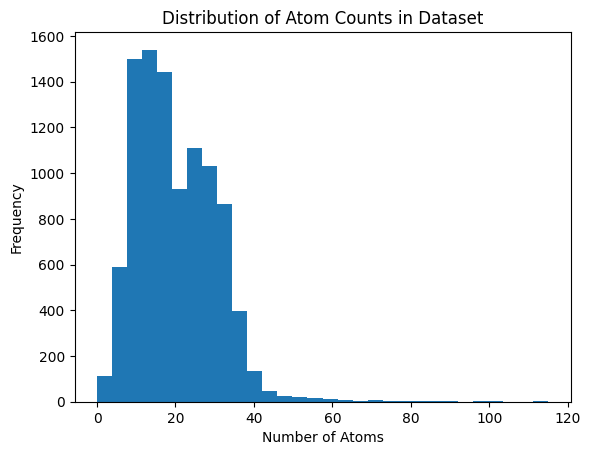

Max atom count: 36


In [3]:
featurizer = QsarGanFeaturizer()
visualizer = Visualizer()

max_atom_count, atom_counts = featurizer.determine_atom_count(smiles=data, quantile=0.95)
visualizer.display_atom_count_distribution(atom_counts)
print(f'Max atom count: {max_atom_count}')

# Featurize the data

Next, we featurize the chemical structures in our dataset using the `QsarGanFeaturizer`. This step involves converting the SMILES strings into feature vectors that can be used as input for the QSAR GAN model.
For simplicity, we set the maximum atom count to 9 as the default value in `BasicMolGAN`. The `get_features` method of the featurizer is used to generate the feature vectors for our dataset.

In [ ]:
featurizer.max_atom_count = 9
features = featurizer.get_features(data.copy())

# Train the Gan and generate data

We now proceed to train the QSAR GAN model using the featurized data. The `QsarGan` class is utilized for this purpose, with the featurizer and learning rate specified as parameters. We set the learning rate to an `ExponentialDecay` function with initial value 0.001, decay rate 0.9, and decay steps 5000. This allows the model to adapt and improve over time.
The `fit_predict` method is called to train the GAN and generate new chemical structures. We specify the number of epochs as 128 for training the model. The generated SMILES strings are obtained as the output of this process.

In [5]:
gan = QsarGan(featurizer=featurizer, learning_rate=ExponentialDecay(0.001, 0.9, 5000))
generated_smiles = gan.fit_predict(features=features, epochs=128)

Ending global_step 767: generator average loss -12.5377, discriminator average loss -14.1932
TIMING: model fitting took 36.051 s
Generating 10000 samples


# Extract Descriptors

In this section, we extract molecular descriptors for the generated SMILES strings using the `DescriptorsExtractor`. This component computes various molecular descriptors for the generated molecules, providing insights into their chemical properties and characteristics. The descriptors are appended to the generated data for further analysis and visualization.

In [6]:
data_with_descriptors = DescriptorsExtractor.extract_descriptors(generated_smiles)
display(data_with_descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
NCCO,7.750000,7.750000,0.097222,0.097222,0.405578,7.500000,61.084,54.028,61.052764,26,...,0,0,0,0,0,0,0,0,0,0
CCCN,5.027778,5.027778,0.819444,0.819444,0.463271,7.500000,59.112,50.040,59.073499,26,...,0,0,0,0,0,0,0,0,0,0
NCNO,7.500000,7.500000,0.125000,0.125000,0.266229,7.500000,62.072,56.024,62.048013,26,...,0,0,0,0,0,0,0,0,0,0
CC,2.000000,2.000000,2.000000,2.000000,0.372786,3.000000,30.070,24.022,30.046950,14,...,0,0,0,0,0,0,0,0,0,0
NCN,4.625000,4.625000,0.250000,0.250000,0.338747,6.000000,46.073,40.025,46.053098,20,...,0,0,0,0,0,0,0,0,0,0
NCO,7.347222,7.347222,0.250000,-0.250000,0.340426,6.000000,47.057,42.017,47.037114,20,...,0,0,0,0,0,0,0,0,0,0
CCNN,4.777778,4.777778,0.847222,0.847222,0.315148,7.500000,60.100,52.036,60.068748,26,...,0,0,0,0,0,0,0,0,0,0
OCO,7.125000,7.125000,0.750000,-0.750000,0.341994,6.000000,48.041,44.009,48.021129,20,...,0,0,0,0,0,0,0,0,0,0
O=CO,8.361111,8.361111,0.250000,-0.250000,0.380161,4.000000,46.025,44.009,46.005479,18,...,0,0,0,0,0,0,0,0,0,0
CCC,2.125000,2.125000,1.250000,1.250000,0.385471,6.000000,44.097,36.033,44.062600,20,...,0,0,0,0,0,0,0,0,0,0


# Display the generated molecules

Finally, we utilize the `Visualizer` component to display the generated molecules based on the SMILES strings. This provides a visual representation of the newly generated chemical structures, aiding in the analysis and interpretation of the GAN output.

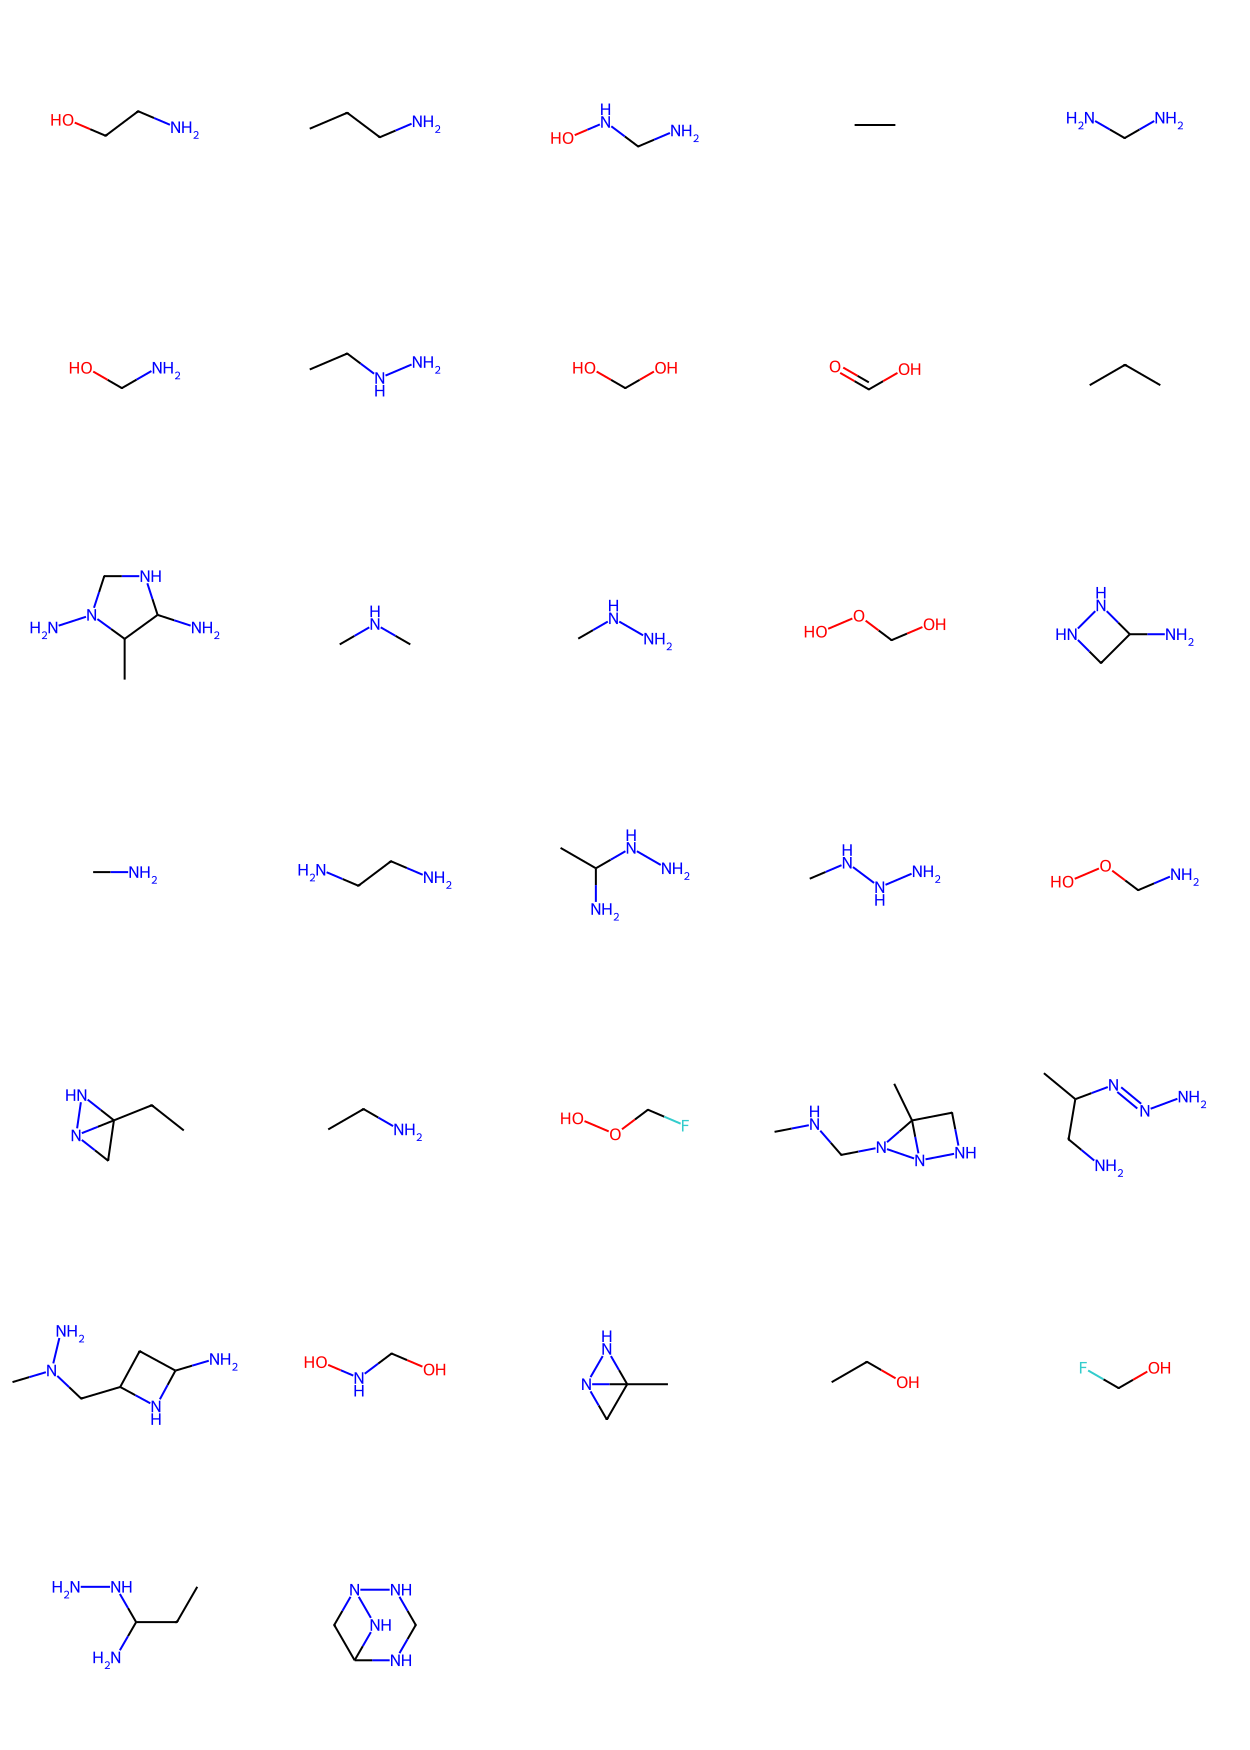

In [7]:
visualizer.draw_generated_molecules(generated_smiles)